# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [7]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [8]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [9]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [10]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [11]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None):
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, plot_roc=True):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
                    
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
        #sample = data_x.sample(fold_size)
        #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
        #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
        display(eli5.show_weights(model, feature_names=list(data_x.columns)))
        
        if plot_roc:
            roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
            #fig = plt.figure()
            #plt.plot(roc_values[0], roc_values[1], 'b-')
            #plt.xlabel("FPR (1-specificity)")
            #plt.ylabel("TPR (recall)")
            #plt.show()
            
            plt.plot(roc_values[2], roc_values[0], 'b-', label="Recall")
            plt.plot(roc_values[2], roc_values[1], 'r-', label="FPR")
            plt.xlabel("Thresholds")
            plt.legend()
            plt.show()
        
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0)

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    for t in thresholds:
        
        
        results = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=t, plot_roc=False)
        print("Threshold:", t)
        display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    

            display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("")
        except Exception as e:
            print(e)

In [12]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"),
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [13]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 757.3 KB


Dummy Random
╠■■■■■■■■■╣


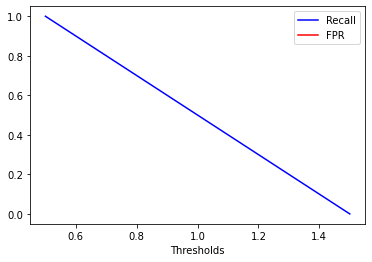

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


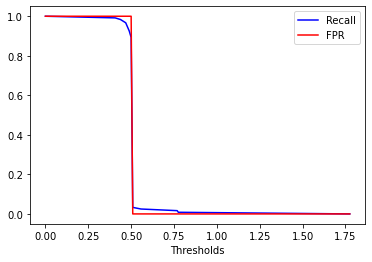

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.504501,0.079923,0.542409,0.929000,0.137347,0.517591
Validation,0.494679,0.074470,0.493803,0.915574,0.126486,0.498963



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0 ± 0.0000,smoker
0 ± 0.0000,autoimmune_dis
0 ± 0.0000,asthma
0 ± 0.0000,cancer
0 ± 0.0000,htn
0 ± 0.0000,chd
0 ± 0.0000,diabetes


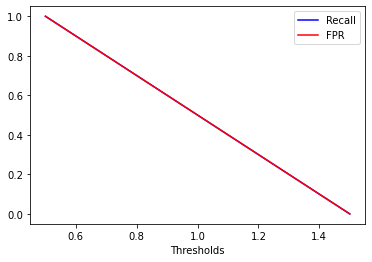

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.501136,0.207182,0.204976,0.795000,0.157361,0.501130
Validation,0.496313,0.204098,0.156123,0.789344,0.145363,0.496788



XGBoost Classifier
╠■■■■■■■■■╣


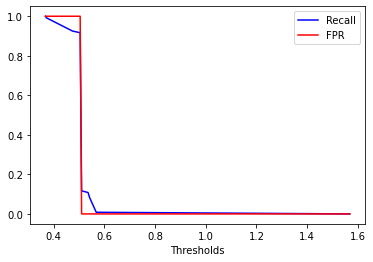

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.516910,0.735909,0.546893,0.297909,0.543293,0.526140
Validation,0.499995,0.714774,0.502547,0.285246,0.524356,0.508991



SVM
╠■■■■■■■■■╣


Weight?,Feature
+0.800,<BIAS>
+0.200,htn
+0.200,diabetes
-0.201,smoker
-1.000,chd
-1.000,cancer
-1.800,autoimmune_dis
-1.801,asthma


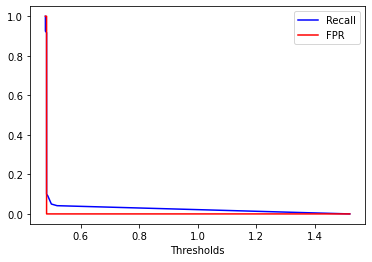

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.496090,0.494645,0.416637,0.497455,0.372444,0.492619
Validation,0.497952,0.492530,0.452036,0.504098,0.377182,0.496985



KNN
╠■■■■■■■■■╣


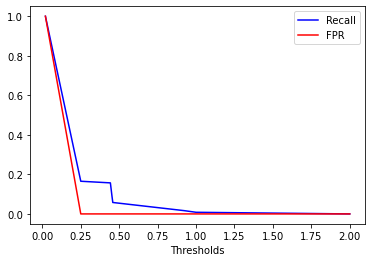

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.510228,0.038464,0.707227,0.981909,0.071807,0.501349
Validation,0.500825,0.029435,0.544986,0.972951,0.054612,0.494920



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.933,diabetes
+0.351,cancer
+0.273,chd
+0.147,autoimmune_dis
+0.046,<BIAS>
-0.123,smoker
-0.200,htn
-0.900,asthma


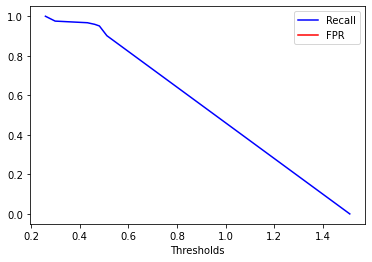

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.516729,0.888612,0.509615,0.144909,0.647608,0.523719
Validation,0.506146,0.883806,0.503516,0.127869,0.641313,0.508180


In [14]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Dummy Random
╠■■■■■■■■■╣


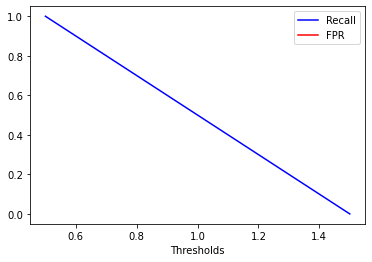

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


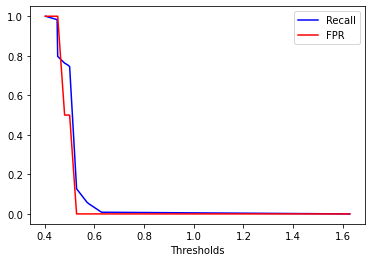

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.526956,0.196304,0.580239,0.857545,0.292660,0.559016
Validation,0.530258,0.196235,0.582993,0.864754,0.290004,0.553533



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.5306 ± 0.8773,high_risk_exposure_occupation
0.4694 ± 0.8417,high_risk_interactions
0 ± 0.0000,autoimmune_dis
0 ± 0.0000,asthma
0 ± 0.0000,cancer
0 ± 0.0000,htn
0 ± 0.0000,chd
0 ± 0.0000,diabetes


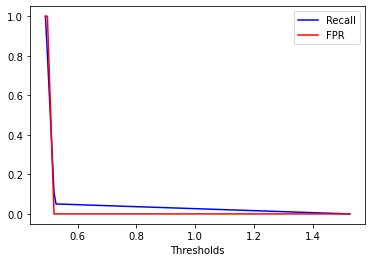

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.532048,0.595455,0.550718,0.468636,0.503791,0.550394
Validation,0.497969,0.554218,0.497859,0.441803,0.467519,0.517176



XGBoost Classifier
╠■■■■■■■■■╣


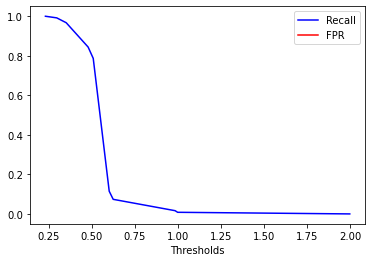

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.545822,0.794975,0.537098,0.296727,0.622323,0.570921
Validation,0.515144,0.751140,0.503501,0.278689,0.586844,0.527104



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.000,diabetes
+1.000,high_risk_exposure_occupation
+1.000,cancer
+0.500,chd
+0.500,htn
-0.001,<BIAS>
-0.999,asthma
-0.999,high_risk_interactions
-1.000,autoimmune_dis


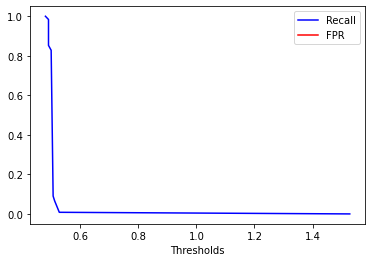

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.529638,0.354543,0.515572,0.704727,0.361953,0.548540
Validation,0.507815,0.314914,0.482181,0.700820,0.323095,0.533298



KNN
╠■■■■■■■■■╣


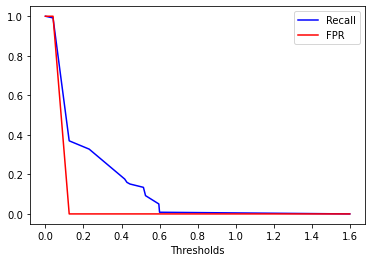

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.520001,0.066374,0.743922,0.973545,0.116719,0.549302
Validation,0.505721,0.050700,0.629380,0.961475,0.089591,0.541175



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.776,cancer
+0.535,chd
+0.526,diabetes
+0.349,high_risk_exposure_occupation
-0.047,<BIAS>
-0.054,htn
-0.069,asthma
-0.078,high_risk_interactions
-0.373,autoimmune_dis


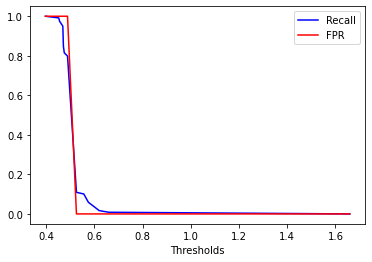

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.537185,0.524188,0.566327,0.550182,0.472006,0.559432
Validation,0.514334,0.493403,0.521424,0.535246,0.436459,0.549942


In [15]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [16]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [17]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

,sys,dia,age
5135,195.0,135.0,4
6106,215.0,115.0,4
9058,200.0,120.0,3
11792,190.0,130.0,3
14314,205.0,125.0,4
19137,215.0,117.0,4
20168,190.0,130.0,4
20379,220.0,140.0,4
20582,200.0,118.0,4
28579,180.0,130.0,3


As expected, all pressure variables (including pam) are correlated between each other

In [18]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


<AxesSubplot:>

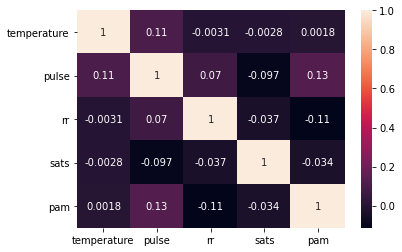

In [19]:
sns.heatmap(vitals.corr(), annot=True)

In [20]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


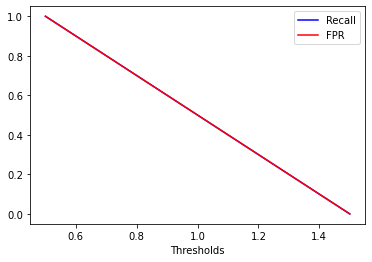

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


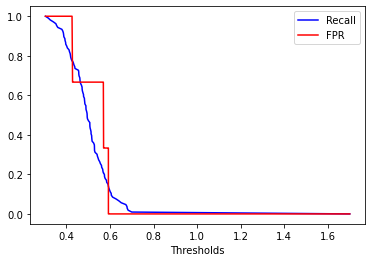

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.564398,0.531696,0.568703,0.597071,0.549564,0.594080
Validation,0.563749,0.525063,0.569190,0.602752,0.545422,0.587725



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3913 ± 0.5656,temperature
0.3384 ± 0.5877,pulse
0.1515 ± 0.4330,pam
0.0928 ± 0.2891,rr
0.0261 ± 0.1307,sats


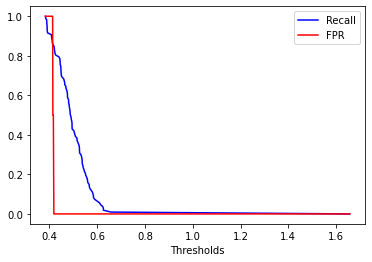

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.610885,0.581439,0.618108,0.640303,0.598655,0.664450
Validation,0.578830,0.546005,0.584747,0.611927,0.561803,0.628694



XGBoost Classifier
╠■■■■■■■■■╣


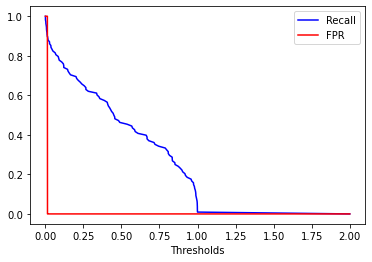

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998130,0.997978,0.998282,0.998283,0.998129,0.999988
Validation,0.539054,0.548707,0.539368,0.529358,0.543273,0.568465



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.102,temperature
+0.129,rr
+0.096,sats
+0.033,pulse
+0.027,pam
-57.158,<BIAS>


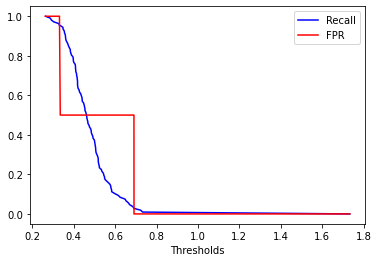

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.587086,0.534022,0.597150,0.640101,0.563781,0.633891
Validation,0.603037,0.536956,0.616965,0.669725,0.571175,0.631703



KNN
╠■■■■■■■■■╣


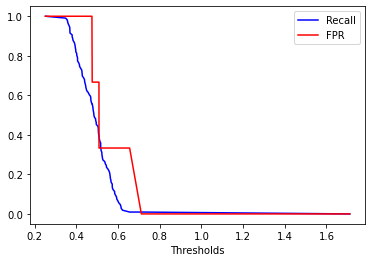

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998383,0.997169,0.999595,0.999596,0.998380,0.999992
Validation,0.554596,0.535963,0.559048,0.573394,0.546162,0.585957



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.958,temperature
+0.046,rr
+0.019,pulse
+0.009,sats
-0.006,pam
-37.849,<BIAS>


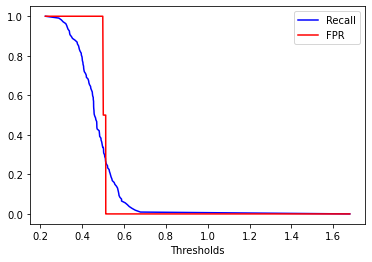

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.588145,0.558487,0.593629,0.617778,0.575473,0.627699
Validation,0.593010,0.556972,0.598313,0.629358,0.574615,0.637439


In [21]:
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


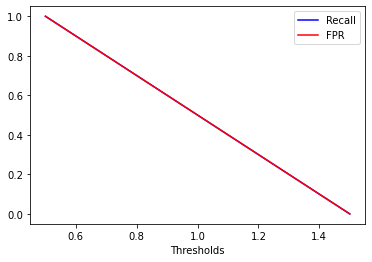

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4601 ± 0.6084,temperature
0.3545 ± 0.5991,pulse
0.0921 ± 0.2642,pam
0.0654 ± 0.2413,rr
0.0279 ± 0.1373,sats


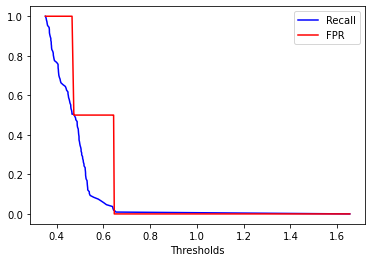

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.614017,0.568294,0.625753,0.659697,0.595110,0.665999
Validation,0.585229,0.547840,0.591444,0.622936,0.567178,0.631195



XGBoost Classifier
╠■■■■■■■■■╣


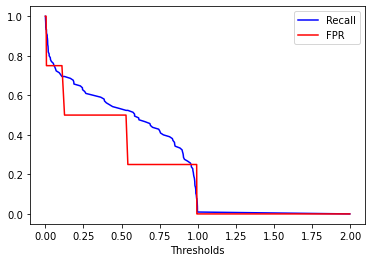

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.997170,0.996866,0.997473,0.997475,0.997168,0.999981
Validation,0.546372,0.545046,0.548371,0.547706,0.545991,0.574355



SVM
╠■■■■■■■■■╣


Weight?,Feature
+0.517,temperature
+0.440,pulse
+0.147,rr
+0.088,sats
+0.071,pam
-0.303,<BIAS>


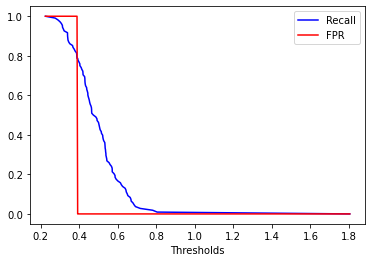

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.592997,0.537965,0.604256,0.647980,0.569146,0.637603
Validation,0.588869,0.535096,0.597426,0.643119,0.562184,0.622725



KNN
╠■■■■■■■■■╣


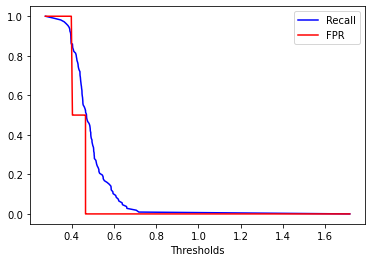

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998787,0.997574,1.000000,1.000000,0.998784,0.999995
Validation,0.589787,0.511376,0.607786,0.668807,0.550582,0.621069



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.294,pulse
+0.239,temperature
+0.209,rr
+0.090,pam
+0.026,sats
-0.152,<BIAS>


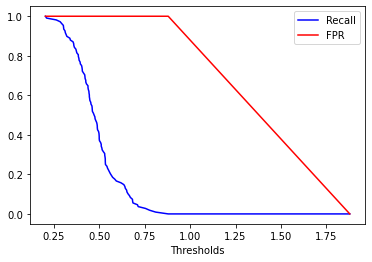

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.590066,0.557073,0.596171,0.623030,0.575933,0.633144
Validation,0.578824,0.553303,0.581042,0.604587,0.565102,0.618100


In [22]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


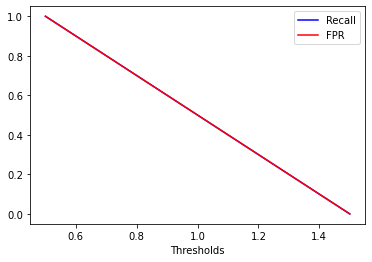

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


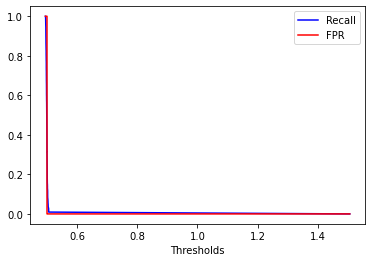

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.576171,0.539885,0.58192,0.612424,0.560088,0.609965
Validation,0.579722,0.535088,0.58662,0.624771,0.557562,0.615749



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4465 ± 0.6012,pulse
0.3522 ± 0.6128,temperature
0.1100 ± 0.3137,pam
0.0497 ± 0.2041,rr
0.0417 ± 0.1740,sats


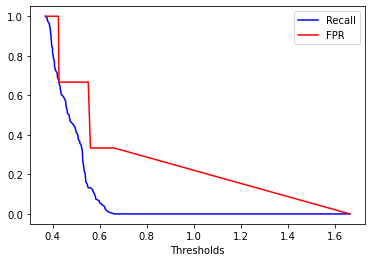

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.613814,0.559706,0.628011,0.667879,0.591302,0.664398
Validation,0.586578,0.518641,0.599096,0.655046,0.551339,0.634466



XGBoost Classifier
╠■■■■■■■■■╣


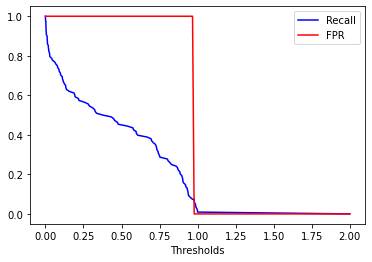

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998080,0.997978,0.998181,0.998182,0.998079,0.999986
Validation,0.544072,0.530450,0.547060,0.557798,0.537419,0.568068



SVM
╠■■■■■■■■■╣


Weight?,Feature
+4.385,temperature
+3.917,pulse
+0.833,rr
-0.043,pam
-0.460,sats
-3.373,<BIAS>


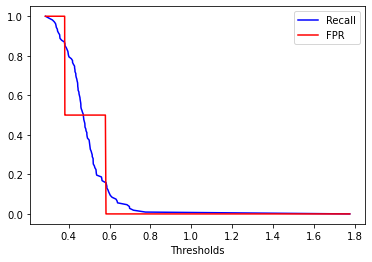

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.587136,0.527248,0.598892,0.646970,0.560733,0.632427
Validation,0.590715,0.525972,0.603004,0.655963,0.560405,0.626704



KNN
╠■■■■■■■■■╣


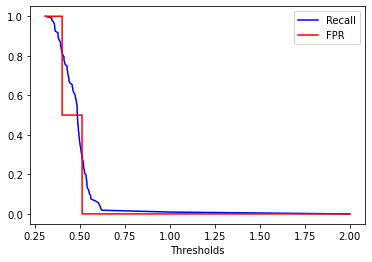

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998484,0.996967,1.000000,1.000000,0.998481,0.999995
Validation,0.571051,0.519616,0.579621,0.622936,0.544770,0.610323



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+2.721,temperature
+1.853,pulse
+0.325,pam
+0.171,rr
-0.733,sats
-1.429,<BIAS>


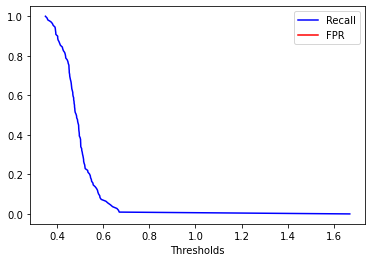

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.592492,0.553535,0.600097,0.631414,0.575849,0.638401
Validation,0.600739,0.546022,0.613137,0.655963,0.574618,0.642793


In [23]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


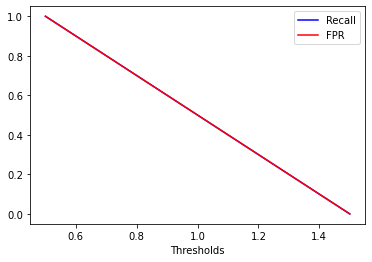

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


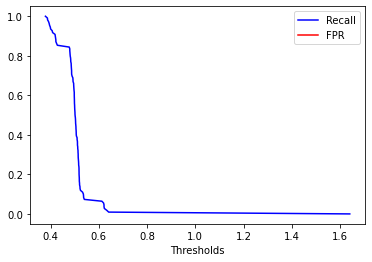

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.560255,0.478502,0.577761,0.641919,0.512781,0.586226
Validation,0.543170,0.464153,0.552793,0.622936,0.494182,0.566710



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3835 ± 0.6979,temperature
0.2962 ± 0.6836,pulse
0.1181 ± 0.4182,pam
0.1034 ± 0.4520,rr
0.0595 ± 0.2645,age
0.0303 ± 0.1577,sats
0.0072 ± 0.0659,high_risk_interactions
0.0017 ± 0.0296,high_risk_exposure_occupation


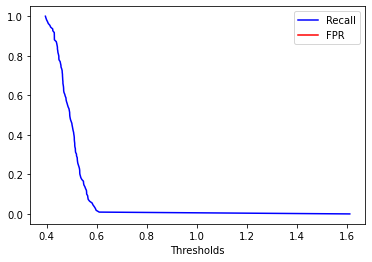

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.621041,0.592865,0.628155,0.649192,0.609798,0.673518
Validation,0.599835,0.565997,0.607074,0.633945,0.584529,0.635731



XGBoost Classifier
╠■■■■■■■■■╣


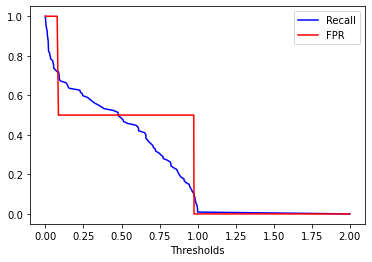

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999747,0.999697,0.999798,0.999798,0.999747,0.999999
Validation,0.550013,0.546822,0.551871,0.553211,0.548166,0.588882



SVM
╠■■■■■■■■■╣


Weight?,Feature
+4.331,temperature
+3.585,pulse
+2.037,pam
+1.259,rr
+0.555,high_risk_exposure_occupation
+0.299,sats
+0.007,age
-0.506,high_risk_interactions
-4.750,<BIAS>


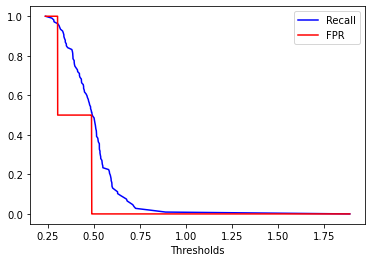

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.602092,0.553030,0.613003,0.651111,0.581422,0.649574
Validation,0.593429,0.544153,0.602254,0.643119,0.569372,0.640710



KNN
╠■■■■■■■■■╣


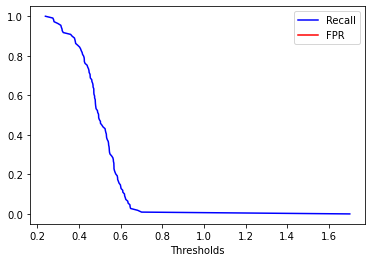

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999747,0.999495,1.000000,1.000000,0.999747,1.00000
Validation,0.579266,0.540459,0.589134,0.618349,0.561415,0.61519



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+2.412,temperature
+1.606,pulse
+1.066,rr
+0.838,pam
+0.360,high_risk_exposure_occupation
-0.054,age
-0.103,sats
-0.322,high_risk_interactions
-2.103,<BIAS>


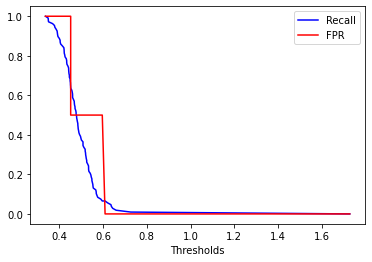

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.601890,0.567588,0.609235,0.636162,0.587663,0.648306
Validation,0.588865,0.556906,0.593047,0.621101,0.572857,0.631562


In [24]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

### Assesed Symptoms

In [25]:
a_symptoms.dropna(how="all", inplace=True)

Dummy Random
╠■■■■■■■■■╣


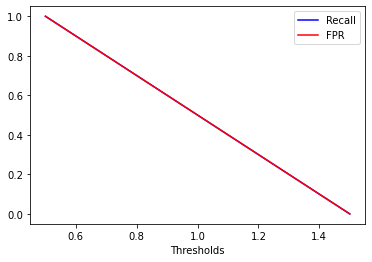

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500070,0.0,0.0,1.0,0.0,0.5
Validation,0.499372,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


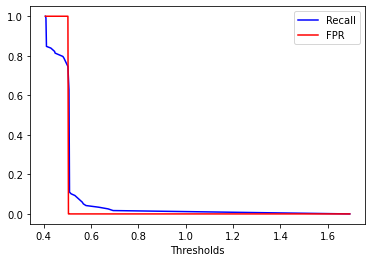

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.545280,0.847628,0.528183,0.243017,0.650814,0.552175
Validation,0.541296,0.847304,0.525473,0.234454,0.648558,0.543718



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.6614 ± 0.9546,days_since_symptom_onset
0.2128 ± 0.6579,wheezes
0.1257 ± 0.5122,ctab
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration


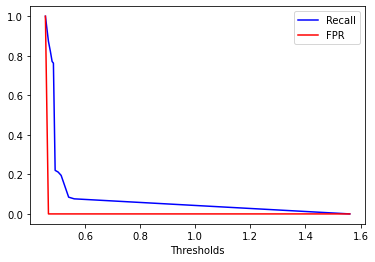

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.591191,0.398343,0.648865,0.783985,0.493452,0.613431
Validation,0.590450,0.399867,0.644649,0.781513,0.491413,0.614029



XGBoost Classifier
╠■■■■■■■■■╣


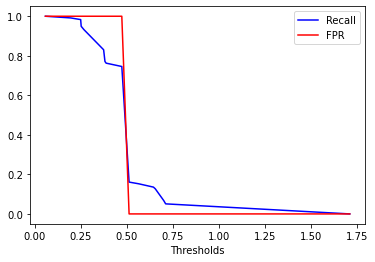

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.605950,0.407937,0.675656,0.803911,0.508555,0.644122
Validation,0.596737,0.383971,0.667732,0.810084,0.486214,0.616482



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.034,<BIAS>
+1.000,labored_respiration
-0.000,rhonchi
-0.000,ctab
-0.017,days_since_symptom_onset
-1.982,wheezes


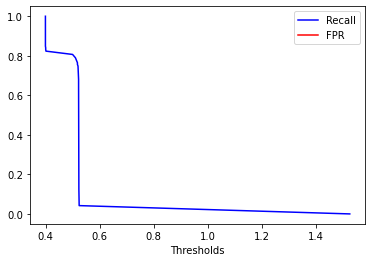

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.539227,0.851163,0.524189,0.227374,0.648711,0.535852
Validation,0.537115,0.843249,0.523828,0.230252,0.646014,0.532720



KNN
╠■■■■■■■■■╣


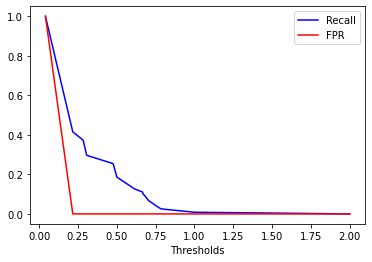

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.603250,0.398714,0.675006,0.807728,0.501145,0.593187
Validation,0.590435,0.383158,0.655173,0.798319,0.482462,0.572607



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.559,labored_respiration
+0.151,wheezes
+0.107,<BIAS>
-0.007,days_since_symptom_onset
-0.285,rhonchi
-0.514,ctab


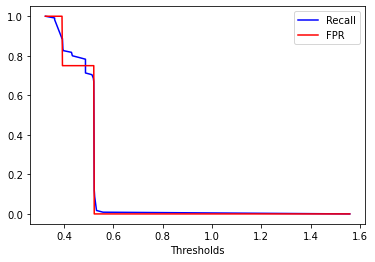

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.550123,0.829837,0.532127,0.270484,0.648402,0.547375
Validation,0.536270,0.820567,0.523389,0.251261,0.639091,0.529707


In [26]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


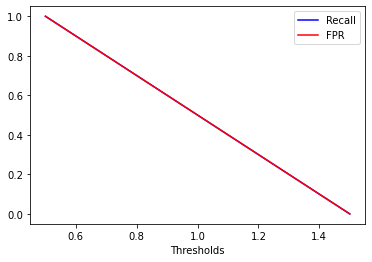

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500070,0.0,0.0,1.0,0.0,0.5
Validation,0.499372,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


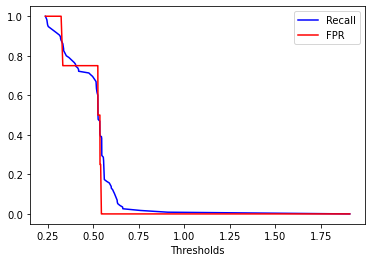

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.555338,0.747314,0.539665,0.363408,0.625104,0.570725
Validation,0.553919,0.758522,0.538681,0.348739,0.628625,0.559821



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3020 ± 0.7927,age
0.2488 ± 0.7777,days_since_symptom_onset
0.1331 ± 0.5435,ctab
0.1118 ± 0.5077,high_risk_interactions
0.1071 ± 0.5749,wheezes
0.0971 ± 0.5451,high_risk_exposure_occupation
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration


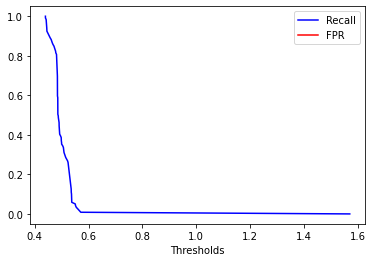

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.594683,0.533478,0.610975,0.655866,0.566529,0.632417
Validation,0.584972,0.507171,0.600605,0.663025,0.544934,0.620724



XGBoost Classifier
╠■■■■■■■■■╣


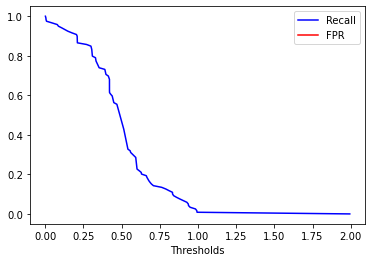

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.647530,0.570539,0.680556,0.724488,0.615977,0.724799
Validation,0.545538,0.459426,0.555025,0.631933,0.498285,0.578962



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,high_risk_exposure_occupation
+1.999,labored_respiration
+0.000,rhonchi
-0.000,days_since_symptom_onset
-0.000,ctab
-0.000,wheezes
-0.000,high_risk_interactions
-1.000,<BIAS>


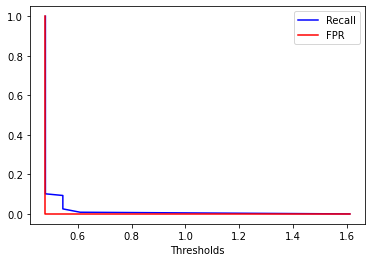

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.555151,0.730927,0.541473,0.379423,0.620151,0.567328
Validation,0.521641,0.709188,0.513889,0.333613,0.593894,0.526128



KNN
╠■■■■■■■■■╣


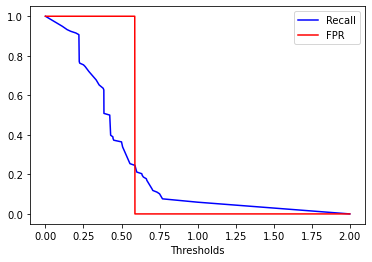

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.644644,0.437831,0.746760,0.851397,0.551878,0.680761
Validation,0.565242,0.356190,0.613827,0.774790,0.449476,0.557830



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.651,high_risk_exposure_occupation
+0.126,<BIAS>
+0.099,labored_respiration
+0.069,wheezes
+0.016,age
-0.017,days_since_symptom_onset
-0.305,ctab
-0.442,high_risk_interactions
-0.565,rhonchi


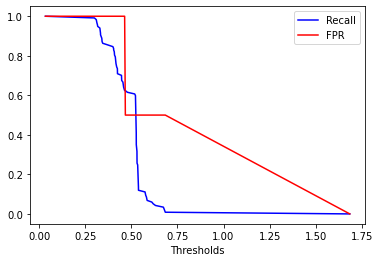

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.560133,0.701383,0.547147,0.418901,0.612271,0.585428
Validation,0.557308,0.696744,0.544108,0.417647,0.607409,0.569710


In [27]:
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

### Reported symptoms

In [28]:
r_symptoms

,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,True,3.0,NaN,False,0.0,False,False,False,False,False,False,False,False
1,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
2,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,2.0,False,True,2.0,False,True,False,False,False,False,False,True
4,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False
93990,True,2.0,False,False,0.0,False,False,False,False,False,True,False,True
93991,False,0.0,True,False,0.0,False,False,False,False,False,False,False,False
93993,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False


In [29]:
r_symptoms.dropna(how="all", inplace=True)

Dummy Random
╠■■■■■■■■■╣


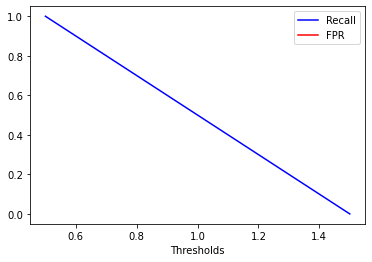

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


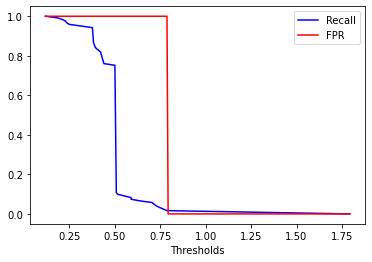

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.632466,0.366974,0.782397,0.897909,0.499403,0.615037
Validation,0.623650,0.364094,0.754191,0.883607,0.488575,0.604064



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.2807 ± 0.7881,cough
0.2702 ± 0.7833,cough_severity
0.1912 ± 0.6615,headache
0.1223 ± 0.5430,fever
0.1149 ± 0.5336,fatigue
0.0151 ± 0.2001,sore_throat
0.0057 ± 0.0832,muscle_sore
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell


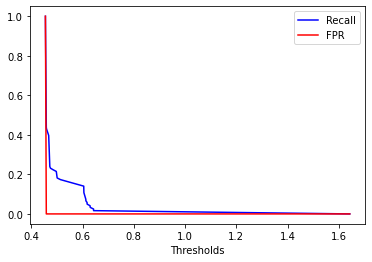

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.63574,0.437898,0.724519,0.833545,0.545744,0.664673
Validation,0.63308,0.433653,0.717566,0.832787,0.537353,0.659846



XGBoost Classifier
╠■■■■■■■■■╣


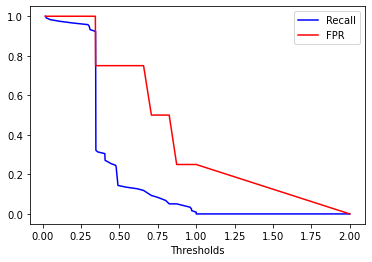

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.704245,0.509367,0.834925,0.899091,0.632524,0.756772
Validation,0.639195,0.445842,0.723992,0.832787,0.548871,0.642849



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+1.999,loss_of_taste
+1.999,cough
+0.001,headache
+0.001,muscle_sore
+0.000,cough_severity
+0.000,sob_severity
+0.000,sore_throat
+0.000,fever
+0.000,diarrhea


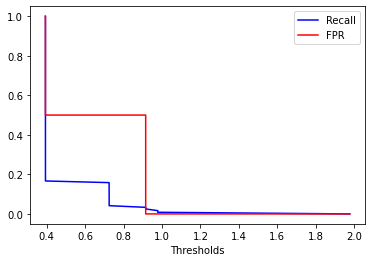

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.650377,0.437352,0.763000,0.863364,0.555187,0.682211
Validation,0.643719,0.428742,0.748072,0.859016,0.542377,0.682056



KNN
╠■■■■■■■■■╣


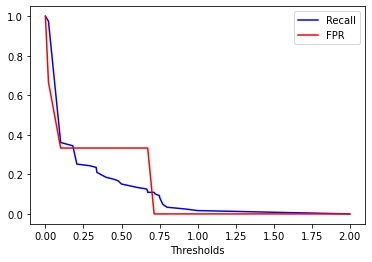

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.702927,0.484633,0.860601,0.921182,0.619826,0.737984
Validation,0.642477,0.436046,0.740541,0.849180,0.545754,0.645800



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.652,loss_of_smell
+1.256,loss_of_taste
+0.907,cough
+0.477,headache
+0.457,sob
+0.424,fever
+0.275,muscle_sore
+0.222,cough_severity
-0.173,fatigue
-0.233,runny_nose


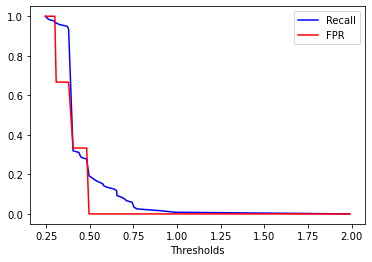

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.663378,0.482906,0.755820,0.843818,0.589146,0.690517
Validation,0.665015,0.479488,0.761026,0.850820,0.585490,0.688252


In [30]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


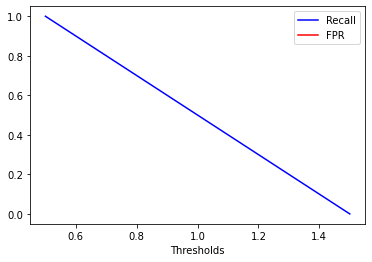

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


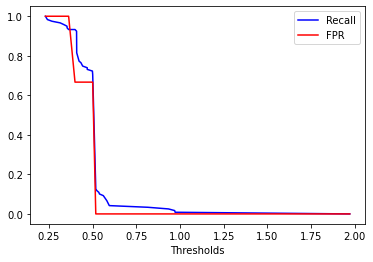

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.623284,0.345606,0.77732,0.900909,0.478251,0.602238
Validation,0.616686,0.335413,0.76497,0.898361,0.463278,0.586549



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4827 ± 0.8909,cough_severity
0.2593 ± 0.7147,headache
0.1505 ± 0.5920,fever
0.0606 ± 0.3928,fatigue
0.0469 ± 0.3418,sore_throat
0 ± 0.0000,muscle_sore
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell
0 ± 0.0000,diarrhea


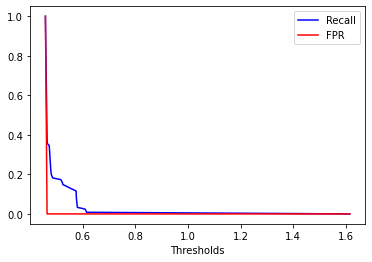

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.637513,0.475176,0.703683,0.799818,0.567222,0.667616
Validation,0.639231,0.473750,0.707234,0.804918,0.563481,0.668320



XGBoost Classifier
╠■■■■■■■■■╣


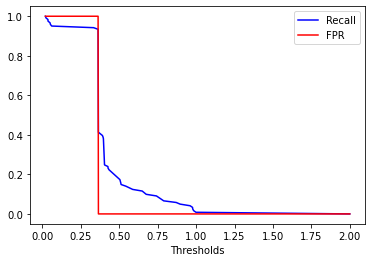

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.705837,0.511365,0.837052,0.900273,0.634635,0.756819
Validation,0.632656,0.438518,0.712733,0.827049,0.541016,0.644478



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.999,loss_of_smell
+1.333,cough_severity
+0.999,muscle_sore
+0.666,loss_of_taste
+0.666,headache
+0.000,fatigue
+0.000,fever
-0.000,runny_nose
-0.001,sore_throat
-0.334,sob_severity


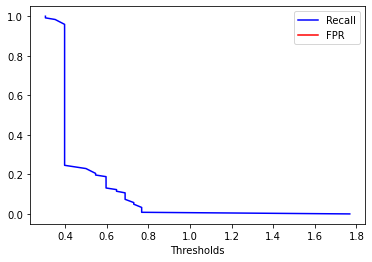

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.661197,0.499451,0.73996,0.822909,0.595774,0.685811
Validation,0.645361,0.487672,0.70750,0.803279,0.573433,0.675970



KNN
╠■■■■■■■■■╣


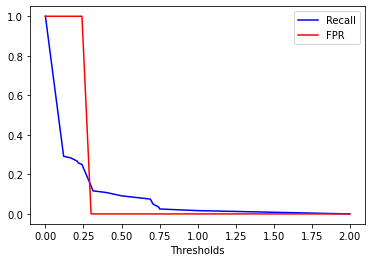

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.702109,0.488087,0.853411,0.916091,0.620842,0.740908
Validation,0.637968,0.437732,0.728182,0.838525,0.544286,0.658566



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.970,loss_of_smell
+1.407,loss_of_taste
+0.979,cough_severity
+0.779,headache
+0.763,muscle_sore
+0.463,fever
+0.061,runny_nose
-0.034,sore_throat
-0.143,sob_severity
-0.498,<BIAS>


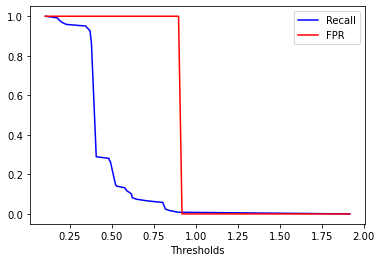

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.659877,0.498103,0.740268,0.821636,0.593634,0.691426
Validation,0.648240,0.487578,0.721548,0.809016,0.577530,0.682074


In [31]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


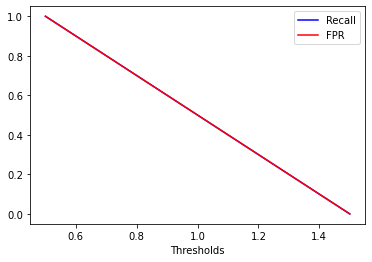

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


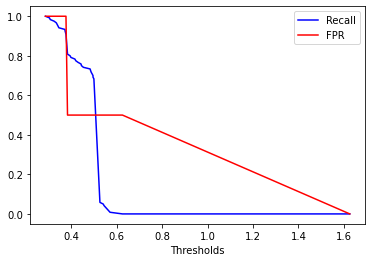

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.614964,0.321146,0.778763,0.908727,0.454148,0.586565
Validation,0.604396,0.310043,0.756510,0.899180,0.435139,0.575455



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3934 ± 0.8413,cough
0.2406 ± 0.7564,headache
0.1317 ± 0.5169,fever
0.0882 ± 0.4838,muscle_sore
0.0821 ± 0.4600,fatigue
0.0639 ± 0.4108,sore_throat
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell
0 ± 0.0000,diarrhea


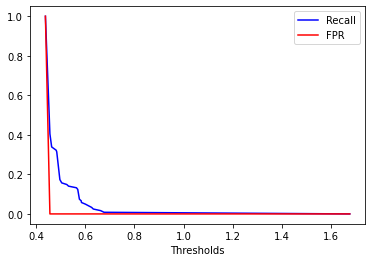

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.639103,0.486268,0.702221,0.791909,0.573319,0.669153
Validation,0.632666,0.468046,0.693525,0.797541,0.555920,0.677282



XGBoost Classifier
╠■■■■■■■■■╣


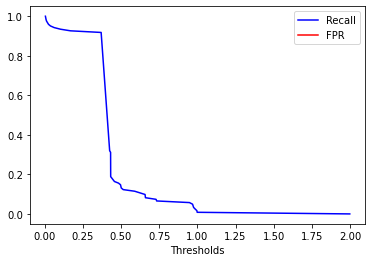

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.698290,0.507001,0.821471,0.889545,0.626810,0.747189
Validation,0.631015,0.437712,0.713249,0.824590,0.539831,0.646255



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,cough
+1.999,loss_of_taste
+1.999,loss_of_smell
+0.001,muscle_sore
+0.000,headache
+0.000,fever
+0.000,runny_nose
-0.000,sore_throat
-0.000,fatigue
-0.000,diarrhea


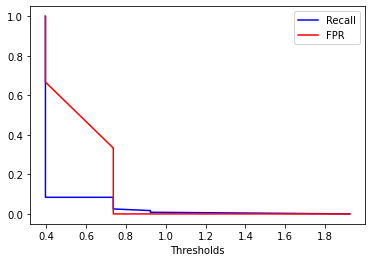

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.653605,0.457085,0.753458,0.850091,0.568562,0.684468
Validation,0.649861,0.455704,0.741247,0.844262,0.558815,0.675102



KNN
╠■■■■■■■■■╣


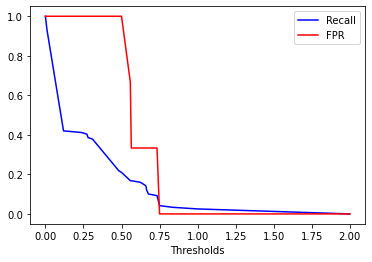

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.698154,0.492819,0.836611,0.903455,0.620068,0.734913
Validation,0.633061,0.432734,0.720114,0.833607,0.536416,0.660784



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.785,loss_of_smell
+1.222,cough
+0.824,muscle_sore
+0.417,headache
+0.332,loss_of_taste
+0.128,fever
-0.085,runny_nose
-0.110,sore_throat
-0.224,sob
-0.429,fatigue


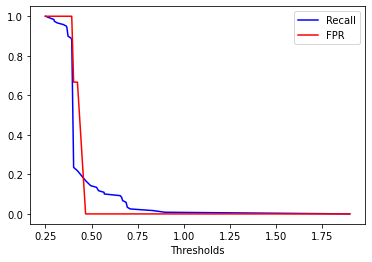

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.667879,0.492543,0.758667,0.843182,0.597159,0.694012
Validation,0.663356,0.488465,0.747773,0.838525,0.588025,0.685016


In [32]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


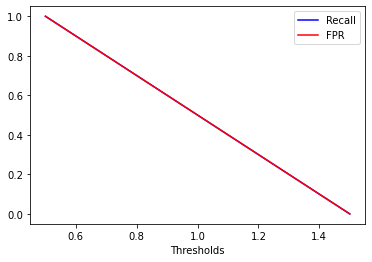

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500070,0.0,0.0,1.0,0.0,0.5
Validation,0.499372,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


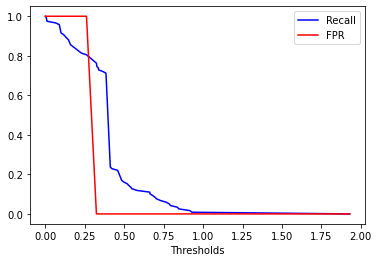

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.645015,0.500420,0.703920,0.789572,0.584915,0.683855
Validation,0.639963,0.500483,0.691163,0.779832,0.577684,0.675691



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3429 ± 0.8972,cough
0.2306 ± 0.7655,headache
0.2272 ± 0.7617,days_since_symptom_onset
0.1340 ± 0.5719,fever
0.0508 ± 0.3208,wheezes
0.0136 ± 0.2006,ctab
0.0008 ± 0.0145,fatigue
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration
0 ± 0.0000,sore_throat


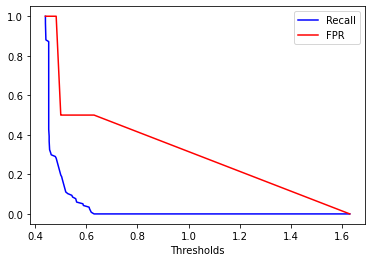

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.647623,0.530037,0.695497,0.765177,0.600358,0.688442
Validation,0.629477,0.524706,0.665529,0.734454,0.581500,0.663226



XGBoost Classifier
╠■■■■■■■■■╣


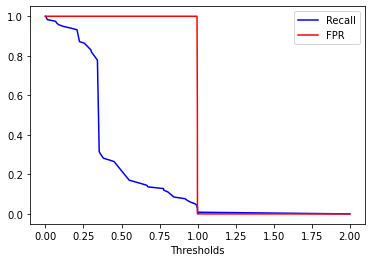

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.760116,0.585546,0.899726,0.934637,0.709307,0.837542
Validation,0.633239,0.450182,0.709529,0.816807,0.548513,0.648212



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,cough
+2.000,loss_of_smell
+1.932,muscle_sore
+0.372,labored_respiration
+0.136,loss_of_taste
+0.068,headache
+0.000,rhonchi
+0.000,fever
+0.000,ctab
-0.000,sore_throat


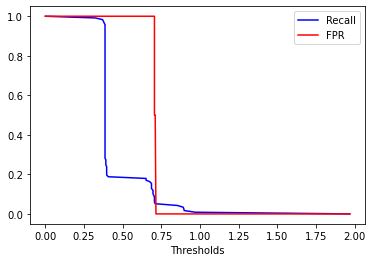

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.660568,0.468757,0.760726,0.852328,0.579643,0.703264
Validation,0.654219,0.468536,0.741952,0.840336,0.570104,0.686733



KNN
╠■■■■■■■■■╣


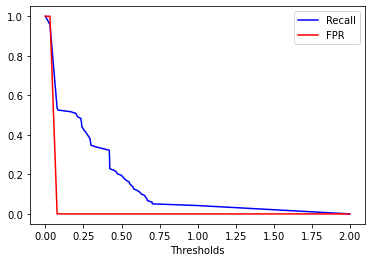

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.762630,0.566267,0.932473,0.958939,0.704533,0.801057
Validation,0.638309,0.459503,0.713637,0.817647,0.557535,0.659616



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.504,loss_of_smell
+0.982,cough
+0.957,loss_of_taste
+0.807,muscle_sore
+0.711,labored_respiration
+0.509,headache
+0.403,fever
+0.027,wheezes
-0.010,days_since_symptom_onset
-0.131,diarrhea


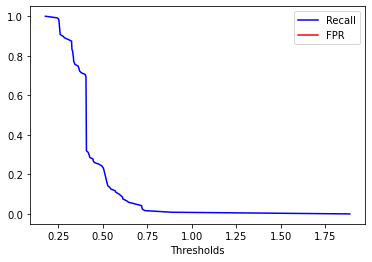

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.668623,0.526495,0.738432,0.810708,0.613248,0.713791
Validation,0.666803,0.513901,0.741929,0.820168,0.599913,0.708974


In [33]:
ra_symptoms = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms, left_index=True, right_index=True)
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


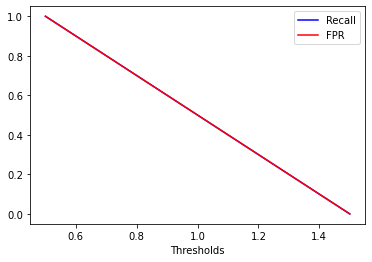

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


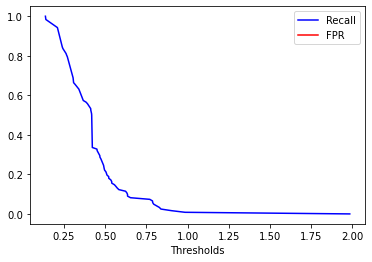

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.647150,0.471359,0.726890,0.822909,0.571799,0.679769
Validation,0.647416,0.469745,0.725941,0.825410,0.568402,0.682503



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.2832 ± 0.8279,cough_severity
0.2107 ± 0.7500,headache
0.1738 ± 0.6404,age
0.1068 ± 0.5205,fever
0.0965 ± 0.5153,high_risk_interactions
0.0547 ± 0.3862,sore_throat
0.0410 ± 0.3597,high_risk_exposure_occupation
0.0333 ± 0.3412,fatigue
0 ± 0.0000,muscle_sore
0 ± 0.0000,runny_nose


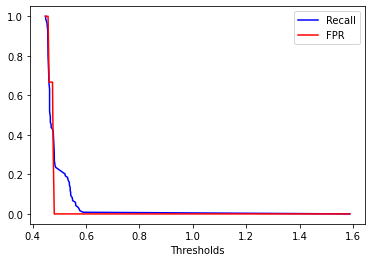

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.638375,0.488728,0.698218,0.788000,0.574679,0.681560
Validation,0.633505,0.478689,0.692875,0.788525,0.561918,0.670038



XGBoost Classifier
╠■■■■■■■■■╣


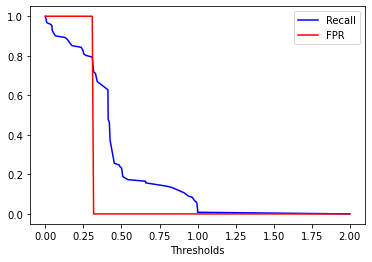

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.750068,0.570468,0.890488,0.929636,0.695297,0.834200
Validation,0.628965,0.443429,0.705620,0.814754,0.543015,0.646391



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.001,loss_of_smell
+1.001,muscle_sore
+1.000,cough_severity
+0.998,loss_of_taste
+0.500,headache
+0.500,high_risk_exposure_occupation
+0.500,fever
+0.499,runny_nose
+0.000,sore_throat
-0.000,age


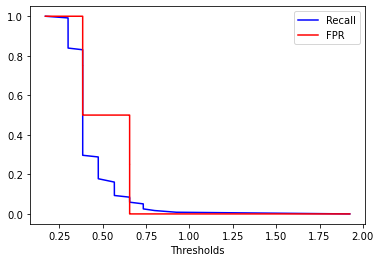

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.658605,0.510915,0.726947,0.806273,0.599013,0.696031
Validation,0.656845,0.505624,0.727535,0.808197,0.592703,0.687316



KNN
╠■■■■■■■■■╣


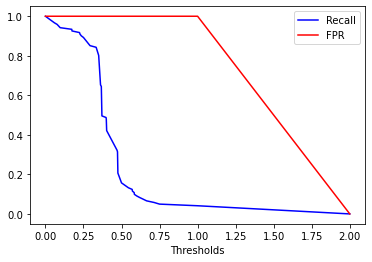

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.750977,0.546551,0.924903,0.955364,0.686881,0.807352
Validation,0.623655,0.400920,0.719139,0.846721,0.511744,0.635970



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.936,loss_of_smell
+1.022,muscle_sore
+0.893,cough_severity
+0.536,loss_of_taste
+0.482,headache
+0.379,fever
+0.123,runny_nose
+0.079,high_risk_exposure_occupation
-0.082,age
-0.185,<BIAS>


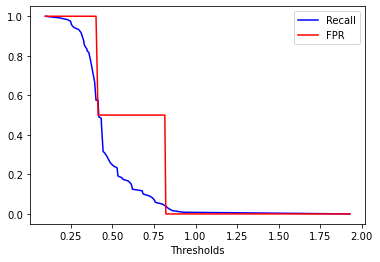

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.657559,0.508456,0.728759,0.806636,0.596987,0.704047
Validation,0.642521,0.489378,0.711248,0.795902,0.574797,0.689590


In [34]:
r_symptoms_ex = pd.merge(r_symptoms.drop(columns=["sob", "cough"]), e_factors, left_index=True, right_index=True)
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


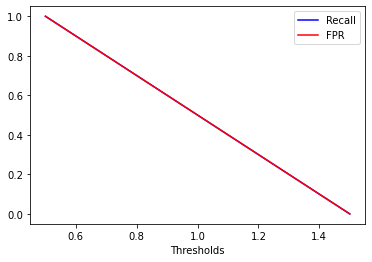

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500227,0.0,0.0,1.0,0.0,0.5
Validation,0.497945,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


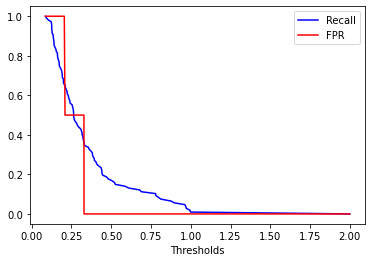

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.658835,0.512586,0.724101,0.804949,0.600178,0.702735
Validation,0.661487,0.514153,0.732461,0.810092,0.601123,0.710398



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.2474 ± 0.6461,pulse
0.2401 ± 0.6659,temperature
0.2130 ± 0.6851,cough
0.0784 ± 0.3783,fever
0.0731 ± 0.3256,sats
0.0727 ± 0.2918,pam
0.0541 ± 0.3674,headache
0.0212 ± 0.2179,rr
0 ± 0.0000,sore_throat
0 ± 0.0000,muscle_sore


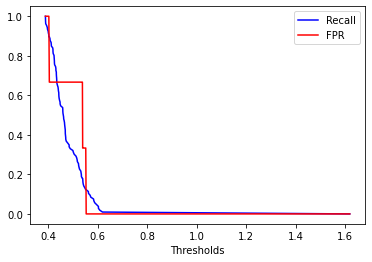

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.661513,0.563043,0.701403,0.759899,0.624079,0.722311
Validation,0.640028,0.547765,0.673797,0.733028,0.601109,0.696445



XGBoost Classifier
╠■■■■■■■■■╣


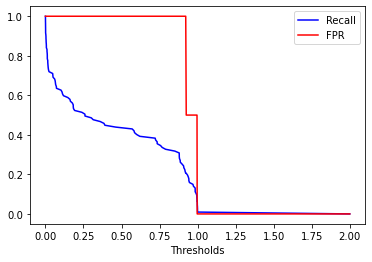

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999646,0.999495,0.999798,0.999798,0.999646,0.999999
Validation,0.624035,0.605104,0.631302,0.643119,0.617498,0.674150



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.634,cough
+1.211,loss_of_smell
+0.986,loss_of_taste
+0.785,muscle_sore
+0.524,fever
+0.445,temperature
+0.260,headache
+0.256,runny_nose
+0.191,diarrhea
+0.076,rr


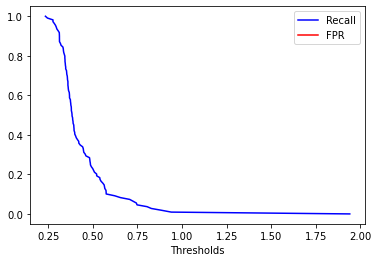

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.666515,0.477001,0.768125,0.855859,0.588124,0.735840
Validation,0.662406,0.462252,0.776084,0.864220,0.574173,0.719446



KNN
╠■■■■■■■■■╣


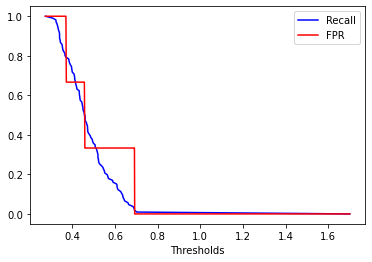

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999545,0.999090,1.000000,1.000000,0.999545,0.999999
Validation,0.580663,0.544229,0.589241,0.617431,0.564774,0.621336



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.518,loss_of_smell
+1.198,cough
+0.574,headache
+0.536,muscle_sore
+0.525,loss_of_taste
+0.393,diarrhea
+0.391,fever
+0.091,rr
+0.081,runny_nose
+0.055,sore_throat


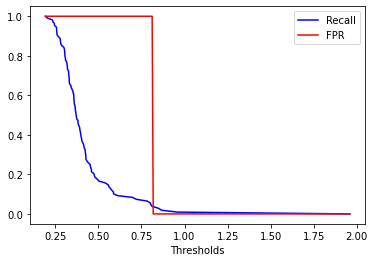

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.671669,0.551918,0.726025,0.791313,0.626873,0.732928
Validation,0.672469,0.543219,0.733349,0.802752,0.622493,0.726538


In [35]:
r_symptoms_vitals = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), vitals, left_index=True, right_index=True)
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


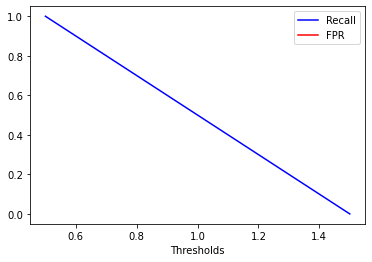

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500127,0.0,0.0,1.0,0.0,0.5
Validation,0.498858,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


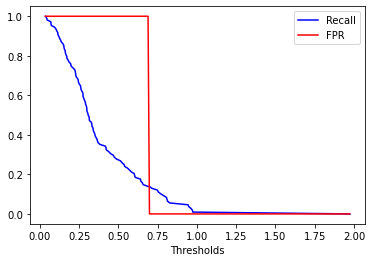

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.660969,0.532727,0.716933,0.789148,0.610986,0.712204
Validation,0.657656,0.526022,0.712861,0.789908,0.603963,0.705547



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.2518 ± 0.6949,pulse
0.1914 ± 0.6828,cough
0.1816 ± 0.5838,temperature
0.0805 ± 0.4059,pam
0.0701 ± 0.4501,headache
0.0564 ± 0.3438,rr
0.0534 ± 0.3950,days_since_symptom_onset
0.0324 ± 0.2578,sats
0.0307 ± 0.2883,ctab
0.0269 ± 0.2380,wheezes


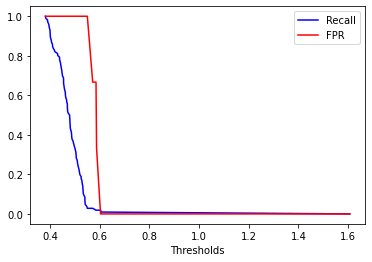

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.664012,0.575241,0.699488,0.752738,0.631216,0.722605
Validation,0.643475,0.553319,0.675012,0.733945,0.604910,0.694910



XGBoost Classifier
╠■■■■■■■■■╣


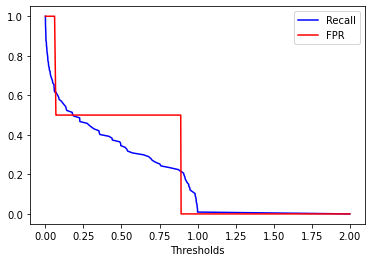

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999696,0.999493,0.999899,0.999899,0.999696,1.000000
Validation,0.620163,0.603786,0.625524,0.636697,0.613721,0.665246



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+1.620,cough
+1.003,muscle_sore
+1.000,labored_respiration
+0.719,loss_of_taste
+0.605,temperature
+0.601,headache
+0.076,rhonchi
+0.062,rr
+0.059,wheezes


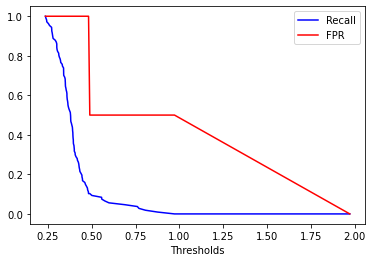

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.673040,0.493961,0.769717,0.852028,0.601301,0.742646
Validation,0.668644,0.489475,0.757863,0.848624,0.591825,0.722529



KNN
╠■■■■■■■■■╣


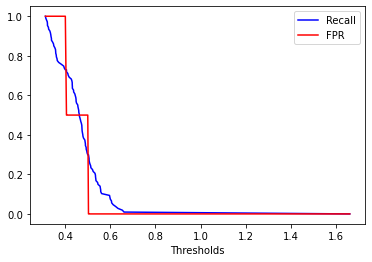

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999645,0.999290,1.000000,1.00000,0.999644,0.999999
Validation,0.573901,0.487623,0.592157,0.66055,0.530342,0.612224



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.364,loss_of_smell
+1.174,cough
+1.108,loss_of_taste
+0.782,muscle_sore
+0.478,fever
+0.366,headache
+0.235,runny_nose
+0.158,wheezes
+0.143,labored_respiration
+0.048,rr


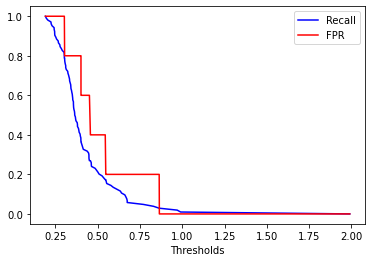

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.678468,0.562046,0.732810,0.794828,0.635873,0.737047
Validation,0.667301,0.552510,0.721463,0.782569,0.621063,0.726140


In [36]:
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


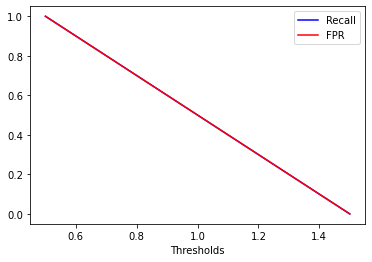

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500045,0.0,0.0,1.0,0.0,0.5
Validation,0.499592,0.0,0.0,1.0,0.0,0.5



MultinomialNB
╠■■■■■■■■■╣


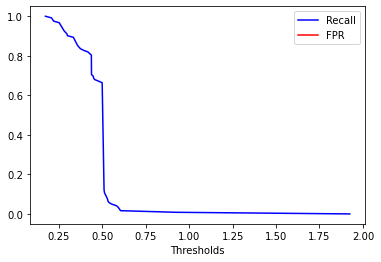

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.640467,0.413167,0.757957,0.867727,0.534558,0.648421
Validation,0.637993,0.409110,0.754159,0.867213,0.527171,0.631715



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4429 ± 0.8662,cough
0.2917 ± 0.7358,headache
0.1697 ± 0.5535,fever
0.0550 ± 0.3301,fatigue
0.0273 ± 0.2369,sore_throat
0.0134 ± 0.1677,muscle_sore
0 ± 0.0000,loss_of_taste
0 ± 0.0000,sob
0 ± 0.0000,diarrhea
0 ± 0.0000,loss_of_smell


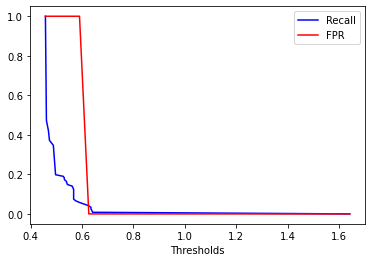

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.642149,0.483269,0.708333,0.801000,0.574343,0.667057
Validation,0.630201,0.475377,0.684302,0.785246,0.558478,0.656707



XGBoost Classifier
╠■■■■■■■■■╣


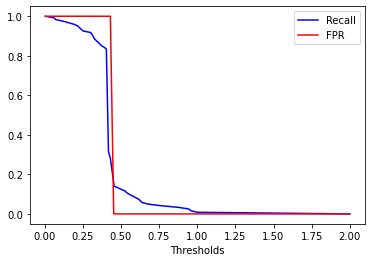

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.713837,0.518638,0.851102,0.909000,0.644251,0.777392
Validation,0.645785,0.449267,0.740043,0.842623,0.558140,0.655110



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+1.999,cough
+1.999,loss_of_taste
+0.667,muscle_sore
+0.666,headache
+0.333,diabetes
+0.001,diarrhea
+0.000,fever
+0.000,sob
-0.000,runny_nose


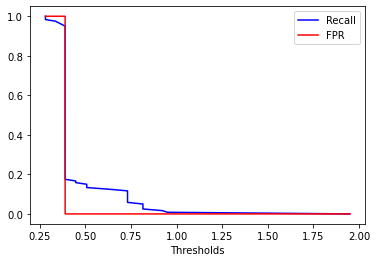

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.656378,0.455177,0.762245,0.857545,0.569242,0.695957
Validation,0.644125,0.448334,0.734187,0.840164,0.553397,0.673616



KNN
╠■■■■■■■■■╣


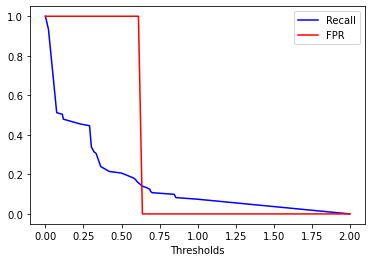

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.718293,0.510910,0.873341,0.925636,0.644483,0.761073
Validation,0.639204,0.419752,0.749274,0.859016,0.534891,0.659742



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.940,loss_of_smell
+1.282,muscle_sore
+1.242,cough
+0.854,loss_of_taste
+0.427,fever
+0.363,diarrhea
+0.277,headache
+0.240,diabetes
+0.240,runny_nose
+0.234,htn


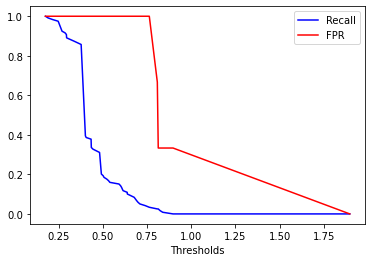

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.668515,0.491362,0.760906,0.845636,0.597072,0.705830
Validation,0.660915,0.478622,0.750636,0.843443,0.581645,0.693518


In [37]:
r_symptoms_comorb = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), comorb, left_index=True, right_index=True)
run_models(r_symptoms_comorb, y[r_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

In [38]:
a = pd.Series(np.array([True, False, True, False]))
b = pd.Series(np.array([True, True, False, False]))

In [39]:
(a ^ b)

0    False
1     True
2     True
3    False
dtype: bool

Next step is to determine which features are useful in the case of each dataset, eliminating them one by one(and maybe applying normalization to the vitals).
After that, we select the 2 (first just 2) best models and somehow combine them to make an ensemble model.<br>
<i>Idea: One model for each metric so 4 models with the highest metrics and then figure out some boolean operation to combine them</i><br>
<i>Idea 2: The boolean operation can be found by using a Decision Tree. After all they are good at finding simple rules</i><br>
<i>Idea 3: The boolean operation taking the highest precision and the highest recall would be an AND. Maybe the inverse for another 2 metrics as well</i>

In [40]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [41]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
'CustomModel' object has no attribute 'predict_proba'


In [42]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [43]:
ensemble_models = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "Logisctic"
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



In [44]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], {"Ada" : AdaBoostClassifier(base_estimator=LogisticRegression())}, folds=10, ratio_negatives_to_positives=1)

Ada
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.679177,0.579295,0.723836,0.779006,0.643420,0.735523
Validation,0.668650,0.566197,0.710832,0.771560,0.629468,0.731872


LogisticVanilla
╠■■■■■■■■■╣


Weight?,Feature
+1.106,loss_of_smell
+0.696,loss_of_taste
+0.601,muscle_sore
+0.514,cough
+0.503,cough_severity
+0.418,high_risk_exposure_occupation
+0.341,diarrhea
+0.325,runny_nose
+0.190,chd
+0.178,fever


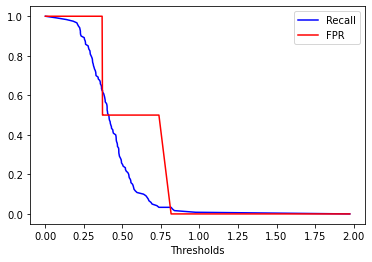

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.676606,0.576739,0.720762,0.776455,0.640618,0.745859
Validation,0.662949,0.550560,0.708728,0.775410,0.617603,0.738361



LogisticStrongRegularization
╠■■■■■■■■■╣


Weight?,Feature
+1.485,loss_of_smell
+1.185,loss_of_taste
+1.013,muscle_sore
+0.570,cough_severity
+0.510,headache
+0.452,diabetes
+0.313,fever
+0.305,cough
+0.286,runny_nose
+0.283,htn


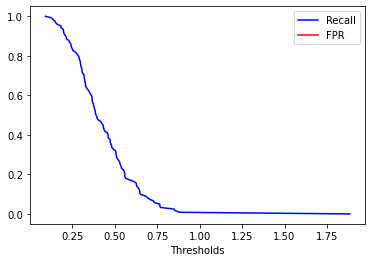

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.675106,0.571648,0.720855,0.778545,0.637609,0.743967
Validation,0.669518,0.553925,0.721058,0.785246,0.624852,0.734500



LogisticWeakRegularization
╠■■■■■■■■■╣


Weight?,Feature
+1.689,loss_of_smell
+1.366,loss_of_taste
+1.135,muscle_sore
+0.589,cough
+0.546,headache
+0.521,cough_severity
+0.330,fever
+0.174,runny_nose
+0.161,labored_respiration
+0.145,temperature


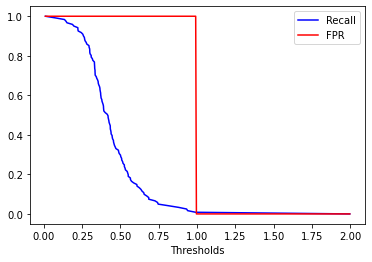

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.678380,0.579649,0.722364,0.777091,0.643048,0.746987
Validation,0.662954,0.551486,0.711172,0.774590,0.618939,0.732673



LogiscticAdaBoost
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.681425,0.588198,0.723138,0.774636,0.648605,0.744278
Validation,0.675632,0.573504,0.719283,0.777869,0.636642,0.731280


In [45]:
run_models(X.drop(columns=["sys", "dia"]), y, ensemble_models, ratio_negatives_to_positives=1)

In [46]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


Weight,Feature
0.2400 ± 0.8542,pulse
0.1200 ± 0.6499,temperature
0.1200 ± 0.6499,days_since_symptom_onset
0.0600 ± 0.4750,cough_severity
0.0600 ± 0.4750,age
0.0400 ± 0.3919,ctab
0.0400 ± 0.3919,rr
0.0400 ± 0.3919,fatigue
0.0400 ± 0.3919,diabetes
0.0200 ± 0.2800,loss_of_taste


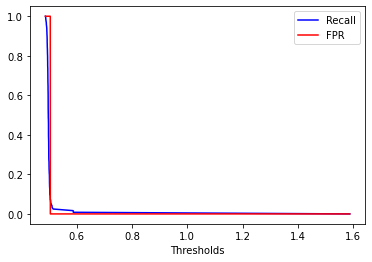

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.692062,0.604652,0.732816,0.779455,0.662399,0.767743
Validation,0.655579,0.553039,0.696233,0.758197,0.613605,0.721011



Ada Logistic
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.680470,0.587197,0.722131,0.773727,0.647526,0.744522
Validation,0.673592,0.574350,0.717257,0.772951,0.635330,0.735880



Ada algo
╠■■■■■■■■■╣


Weight,Feature
0.1911 ± 0.7684,loss_of_smell
0.1883 ± 0.9165,days_since_symptom_onset
0.1478 ± 0.6000,pulse
0.1421 ± 0.6499,temperature
0.0772 ± 0.2800,cough
0.0658 ± 0.6499,rr
0.0629 ± 0.3919,headache
0.0596 ± 0.4750,loss_of_taste
0.0369 ± 0.2800,high_risk_interactions
0.0178 ± 0.2800,htn


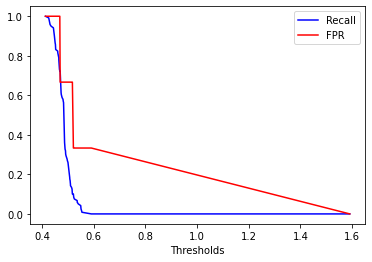

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.677561,0.591193,0.715220,0.763909,0.646440,0.738862
Validation,0.667855,0.566987,0.709618,0.768852,0.627673,0.732909



Ada learning rate
╠■■■■■■■■■╣


Weight,Feature
0.1800 ± 0.7684,pulse
0.1800 ± 0.7684,temperature
0.1400 ± 0.6940,days_since_symptom_onset
0.0600 ± 0.4750,high_risk_interactions
0.0600 ± 0.4750,cough_severity
0.0600 ± 0.4750,rr
0.0400 ± 0.3919,muscle_sore
0.0400 ± 0.3919,asthma
0.0400 ± 0.3919,high_risk_exposure_occupation
0.0400 ± 0.3919,loss_of_smell


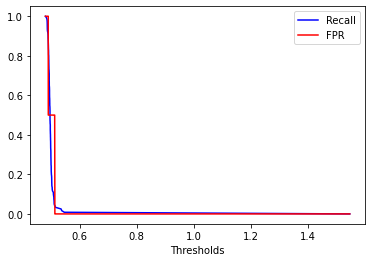

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.692699,0.587830,0.744130,0.797545,0.656403,0.766290
Validation,0.655995,0.549833,0.697909,0.762295,0.612225,0.719777



Ada complete
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.661287,0.618568,0.676591,0.704000,0.645942,0.710947
Validation,0.640423,0.596441,0.653101,0.684426,0.622650,0.692338


In [47]:
run_models(X.drop(columns=["sys", "dia"]), y, ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


Weight,Feature
0.3400 ± 0.9474,pam
0.2800 ± 0.8980,temperature
0.1200 ± 0.6499,pulse
0.0400 ± 0.3919,days_since_symptom_onset
0.0200 ± 0.2800,labored_respiration
0.0200 ± 0.2800,ctab
0.0200 ± 0.2800,muscle_sore
0.0200 ± 0.2800,fever
0.0200 ± 0.2800,loss_of_taste
0.0200 ± 0.2800,loss_of_smell


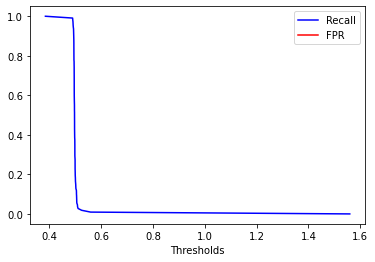

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.697642,0.601014,0.745097,0.794219,0.665130,0.769439
Validation,0.674580,0.567982,0.722680,0.781651,0.633909,0.723979



Ada Logistic
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.676998,0.579905,0.719750,0.774037,0.642153,0.736341
Validation,0.676882,0.581701,0.718737,0.772477,0.641448,0.728628



Ada algo
╠■■■■■■■■■╣


Weight,Feature
0.3581 ± 0.9165,loss_of_smell
0.1408 ± 0.6499,temperature
0.0948 ± 0.2800,cough
0.0770 ± 0.8773,days_since_symptom_onset
0.0727 ± 0.6499,loss_of_taste
0.0586 ± 0.3919,muscle_sore
0.0533 ± 0.2800,pulse
0.0517 ± 0.3919,pam
0.0251 ± 0.2800,diarrhea
0.0242 ± 0.2800,fatigue


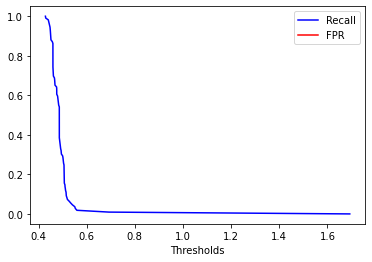

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.678264,0.576050,0.725385,0.780426,0.641206,0.735317
Validation,0.670491,0.569775,0.715983,0.771560,0.630032,0.719436



Ada learning rate
╠■■■■■■■■■╣


Weight,Feature
0.2200 ± 0.8285,temperature
0.1400 ± 0.6940,pulse
0.1200 ± 0.6499,pam
0.0800 ± 0.5426,rr
0.0800 ± 0.5426,muscle_sore
0.0600 ± 0.4750,cough
0.0600 ± 0.4750,fatigue
0.0600 ± 0.4750,loss_of_smell
0.0600 ± 0.4750,rhonchi
0.0400 ± 0.3919,sats


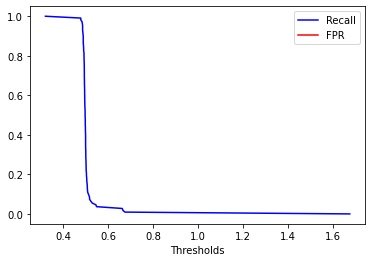

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.696018,0.583661,0.752943,0.808316,0.657366,0.764214
Validation,0.665860,0.561551,0.712384,0.770642,0.625989,0.722536



Ada complete
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.660157,0.628921,0.671623,0.691379,0.648939,0.715131
Validation,0.655352,0.623653,0.668941,0.687156,0.643453,0.706519


In [48]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

In [49]:
run_threshold(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations["Ada algo"], ratio_negatives_to_positives=1)

╠■■■■■■■■■╣


Weight,Feature
0.2830 ± 0.8542,loss_of_smell
0.2754 ± 0.9992,temperature
0.1145 ± 0.4750,muscle_sore
0.1070 ± 0.2800,cough
0.0911 ± 0.5426,loss_of_taste
0.0591 ± 0.3919,headache
0.0408 ± 0.2800,rr
0.0291 ± 0.2800,days_since_symptom_onset
0 ± 0.0000,sob
0 ± 0.0000,pulse


Threshold: 0.0


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499873,1.0,0.499873,0.0,0.666554,0.735450
Validation,0.501142,1.0,0.501142,0.0,0.667680,0.713454


╠■■■■■■■■■╣


Weight,Feature
0.2492 ± 0.8000,loss_of_smell
0.2275 ± 0.8980,temperature
0.1175 ± 0.6940,loss_of_taste
0.1004 ± 0.7684,pam
0.0670 ± 0.3919,muscle_sore
0.0639 ± 0.3919,cough
0.0605 ± 0.4750,days_since_symptom_onset
0.0404 ± 0.2800,pulse
0.0368 ± 0.2800,rr
0.0367 ± 0.2800,ctab


Threshold: 0.1


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499873,1.0,0.499873,0.0,0.666554,0.740160
Validation,0.501142,1.0,0.501142,0.0,0.667680,0.716475


╠■■■■■■■■■╣


Weight,Feature
0.2501 ± 0.8000,loss_of_smell
0.1913 ± 0.9165,temperature
0.1203 ± 0.6940,pulse
0.0941 ± 0.2800,cough
0.0904 ± 0.6499,pam
0.0741 ± 0.3919,headache
0.0623 ± 0.3919,muscle_sore
0.0443 ± 0.5426,days_since_symptom_onset
0.0365 ± 0.2800,loss_of_taste
0.0253 ± 0.2800,runny_nose


Threshold: 0.2


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499873,1.0,0.499873,0.0,0.666554,0.736833
Validation,0.501142,1.0,0.501142,0.0,0.667680,0.716897


╠■■■■■■■■■╣


Weight,Feature
0.1862 ± 0.6940,loss_of_smell
0.1829 ± 0.9798,days_since_symptom_onset
0.1784 ± 0.8000,temperature
0.1114 ± 0.2800,cough
0.0932 ± 0.5426,runny_nose
0.0931 ± 0.2800,pulse
0.0757 ± 0.5426,loss_of_taste
0.0417 ± 0.2800,rr
0.0202 ± 0.2800,muscle_sore
0.0173 ± 0.2800,pam


Threshold: 0.30000000000000004


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499873,1.0,0.499873,0.0,0.666554,0.736612
Validation,0.501142,1.0,0.501142,0.0,0.667680,0.724009


╠■■■■■■■■■╣


Weight,Feature
0.2521 ± 0.8285,loss_of_smell
0.2224 ± 0.9330,temperature
0.1427 ± 0.6000,muscle_sore
0.1408 ± 0.7332,loss_of_taste
0.0931 ± 0.5426,pulse
0.0879 ± 0.2800,cough
0.0339 ± 0.5426,rr
0.0269 ± 0.2800,rhonchi
0 ± 0.0000,sob
0 ± 0.0000,days_since_symptom_onset


Threshold: 0.4


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499975,1.0,0.499924,0.000203,0.666599,0.737081
Validation,0.501142,1.0,0.501142,0.000000,0.667680,0.711192


╠■■■■■■■■■╣


Weight,Feature
0.3919 ± 0.9600,loss_of_smell
0.1276 ± 0.8542,pam
0.1017 ± 0.5426,muscle_sore
0.0802 ± 0.2800,cough
0.0734 ± 0.4750,headache
0.0641 ± 0.4750,pulse
0.0623 ± 0.4750,temperature
0.0381 ± 0.5426,loss_of_taste
0.0331 ± 0.2800,wheezes
0.0275 ± 0.2800,rr


Threshold: 0.5


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.679786,0.583649,0.724410,0.775862,0.644903,0.739277
Validation,0.664549,0.553511,0.714101,0.776147,0.619856,0.719877


╠■■■■■■■■■╣


Weight,Feature
0.2844 ± 0.9600,loss_of_taste
0.2149 ± 0.8285,loss_of_smell
0.1608 ± 0.6940,temperature
0.0776 ± 0.2800,cough
0.0678 ± 0.3919,pulse
0.0497 ± 0.4750,rr
0.0399 ± 0.3919,headache
0.0340 ± 0.4750,muscle_sore
0.0243 ± 0.2800,pam
0.0235 ± 0.2800,runny_nose


Threshold: 0.6000000000000001


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.546742,0.098531,0.949596,0.994726,0.178404,0.735299
Validation,0.545518,0.097623,0.947459,0.995413,0.175590,0.716922


╠■■■■■■■■■╣


Weight,Feature
0.3677 ± 0.9330,loss_of_smell
0.1684 ± 0.6499,temperature
0.1670 ± 0.9708,days_since_symptom_onset
0.0960 ± 0.5426,muscle_sore
0.0955 ± 0.2800,cough
0.0540 ± 0.2800,pulse
0.0289 ± 0.3919,headache
0.0224 ± 0.2800,pam
0 ± 0.0000,rr
0 ± 0.0000,wheezes


Threshold: 0.7000000000000001


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.503424,0.006596,1.0,1.0,0.013098,0.736326
Validation,0.502057,0.006372,0.4,1.0,0.012501,0.719140


╠■■■■■■■■■╣


Weight,Feature
0.2879 ± 0.8542,loss_of_smell
0.2434 ± 0.9600,pulse
0.1032 ± 0.4750,temperature
0.0900 ± 0.2800,cough
0.0698 ± 0.4750,headache
0.0600 ± 0.4750,days_since_symptom_onset
0.0492 ± 0.4750,loss_of_taste
0.0468 ± 0.2800,rr
0.0266 ± 0.2800,muscle_sore
0.0231 ± 0.6000,pam


Threshold: 0.8


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500127,0.0,0.0,1.0,0.0,0.735809
Validation,0.498858,0.0,0.0,1.0,0.0,0.703880


╠■■■■■■■■■╣


Weight,Feature
0.1782 ± 0.6000,temperature
0.1740 ± 0.6499,loss_of_smell
0.1674 ± 0.9474,days_since_symptom_onset
0.1457 ± 0.4750,muscle_sore
0.1086 ± 0.2800,cough
0.0767 ± 0.2800,pulse
0.0668 ± 0.8980,pam
0.0417 ± 0.3919,loss_of_taste
0.0409 ± 0.2800,rhonchi
0 ± 0.0000,rr


Threshold: 0.9


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500127,0.0,0.0,1.0,0.0,0.739882
Validation,0.498858,0.0,0.0,1.0,0.0,0.701747


╠■■■■■■■■■╣


Weight,Feature
0.4379 ± 0.9992,loss_of_smell
0.1978 ± 0.9165,loss_of_taste
0.1318 ± 0.6000,temperature
0.0861 ± 0.2800,cough
0.0651 ± 0.4750,muscle_sore
0.0532 ± 0.2800,pulse
0.0281 ± 0.2800,rr
0 ± 0.0000,sob
0 ± 0.0000,days_since_symptom_onset
0 ± 0.0000,wheezes


Threshold: 1.0


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500127,0.0,0.0,1.0,0.0,0.737705
Validation,0.498858,0.0,0.0,1.0,0.0,0.708160


## Sidequest: Understanding logistic regression

In [ ]:
lr = LogisticRegression()
imp = Imputer()
imp.fit_transform(all_data, y[all_data.index])
lr.fit(all_data, y[all_data.index], sample_weight=(np.ones(y[all_data.index].shape) + (y[all_data.index]=="Negative")))

In [ ]:
lr_preds = lr.predict(all_data)

In [ ]:
manual_preds = np.dot(all_data, lr.coef_.transpose()) + lr.intercept_ #The dot product of coeficients and features plus the bias

In [ ]:
from math import exp
def logistic_function(value):
    return 1 / (1 + exp(-value))

In [ ]:
manual_preds.flatten()

In [ ]:
lfv = np.vectorize(logistic_function) #To vectorize means to apply it to vectors

In [ ]:
result = pd.Series(lfv(manual_preds).flatten())
result[result > .5] = "Positive"
result[result != "Positive"] = "Negative"

In [ ]:
a = np.array([[1,2,3,4,5],[2,4,6,8,10]])
b = np.ones((5,2))
b[:,1] *= 2

In [ ]:
np.dot(a, b)

In [ ]:
lfv(manual_preds)[lfv(manual_preds) > .5]

In [ ]:
explainer = shap.KernelExplainer(lr.predict_proba, np.zeros((1,all_data.columns.size)))

In [ ]:
shap_values = explainer.shap_values(all_data[y[all_data.index] == "Positive"].sample(1))

In [ ]:
shap_values

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], all_data.columns)

In [ ]:
ra_symptoms_vitals.columns

In [ ]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))

In [ ]:
lr.fit(all_data, y[all_data.index])
calculate_shap_values(lr, all_data)

In [ ]:
y[all_data.index].value_counts()

In [ ]:
all_data["sats"]